<h1> Plot word2vec </h1>

In [168]:
# gensim modules
from __future__ import division
from gensim import utils
from gensim.models.doc2vec import LabeledSentence, TaggedDocument
from gensim.models import Doc2Vec, Word2Vec

# numpy
import numpy as np
import re

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from collections import defaultdict

%pylab inline
pylab.rcParams['figure.figsize'] = (16.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})
import psycopg2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Populating the interactive namespace from numpy and matplotlib


In [4]:
QmodelB=Word2Vec.load('/home/ubuntu/TallLabs/models/QmodelB')

<h1> load in labeled sentences </h1>

In [12]:
conn = psycopg2.connect("host=localhost port=5432 dbname=amazon user=postgres password=darkmatter")
cur = conn.cursor()

In [463]:
cur.execute("SELECT question,qestion_type,qestion_type_bow,qestion_type_human from training \
WHERE qestion_type_human  = 'yes/no' and (name='Attila' or name='Ruth' or name='Jeremy');")
#and (name='Attila' or name='Ruth' or name='Jeremy')
result=cur.fetchall()
Qyn=[val[0] for val in result]
Qyn_Type_data=[val[1] for val in result]
Qyn_Type_bow=[val[2] for val in result]

cur.execute("SELECT question,qestion_type,qestion_type_bow,qestion_type_human from training \
WHERE qestion_type_human  = 'open-ended'and (name='Attila' or name='Ruth' or name='Jeremy');") #and (name!='Aysen' and name!='')
result=cur.fetchall()
Qoe=[val[0] for val in result]
Qoe_Type_data=[val[1] for val in result]
Qoe_Type_bow=[val[2] for val in result]

In [464]:
def process_line(sentence):
    filter_text=' '.join(re.findall("[a-z']+", sentence.lower())) #removed ?
    #return nltk.word_tokenize(filter_text)
    return filter_text.replace('?',' ? ').split()
stoplist = set('for a of the and to in rt'.split())

In [470]:
qs_yn= [[word for word in process_line(sentence) if word not in stoplist] for sentence in Qyn ]
#shuffle and take the first 1/2 for training
shuffle(qs_yn)
qs_yn_sample=qs_yn[:int(len(qs_yn)/2)]

qs_oe= [[word for word in process_line(sentence) if word not in stoplist] for sentence in Qoe ]
#shuffle and take the first 1/2 for training, can also do random sampling
shuffle(qs_oe)
qs_oe_sample=qs_oe[:int(len(qs_oe)/2)]

<h1> extract first words for PCA </h1>

In [471]:
words_yn=[word[2] for word in qs_yn if len(word)>2]
words_oe=[word[2] for word in qs_oe if len(word)>2]

<h1> use PCA to reduce dimensionality of word vectors </h1>

In [472]:
vectors_yn = []
words_yn_pass=[]

words_yn=[word[0] for word in qs_yn if len(word)>2]
words_oe=[word[0] for word in qs_oe if len(word)>2]

for word in words_yn:
    try:
        vectors_yn.append(QmodelB[word])
        words_yn_pass.append(word)
    except KeyError:
        pass
vectors_oe = []
words_oe_pass=[]
for word in words_oe:
    try:
        vectors_oe.append(QmodelB[word])
        words_oe_pass.append(word)
    except KeyError:
        pass
vectors=vectors_yn+vectors_oe
words_pass=words_yn_pass+words_oe_pass

<h3> PCA </h3>

In [310]:
pca = PCA(n_components=1, whiten=True)
#pcaFit=pca.fit(vectors)
vectors2d = pca.fit(vectors).transform(vectors)

In [306]:
vectors2d = pcaFit.transform(vectors)

<h3> TSNE </h3>

In [473]:
tsne = TSNE(n_components=2, random_state=0)
vectors2d = tsne.fit_transform(vectors)

<h3> 2d scatter </h3>

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


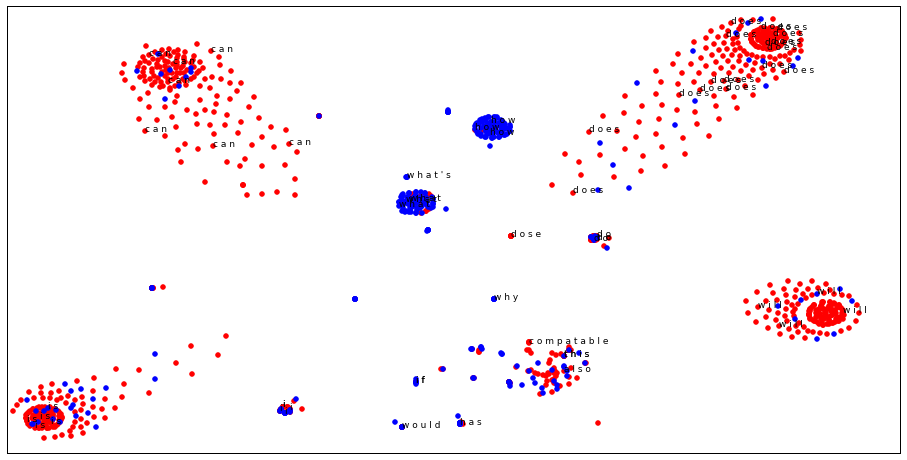

In [483]:
Nyn=len(vectors_yn)
plt.scatter(vectors2d[:Nyn,0],vectors2d[:Nyn,1],color='r')
plt.scatter(vectors2d[Nyn:,0],vectors2d[Nyn:,1],color='b')

interesting_words=["i","does","how","is","what","could","should","anyone","will","where","can"]
S=defaultdict(lambda:0)
for ii,val in enumerate(vectors2d):
    #if words_pass[ii] in interesting_words:
    #    S[words_pass[ii]]+=1
    #    if S[words_pass[ii]]<=1:
    #        plt.text(val[0],val[1],words_pass[ii],fontsize=18)
    if ii%20==0:
        #print(' '.join(words_pass[ii]))
        plt.text(val[0],val[1],' '.join(words_pass[ii]),fontsize=9)
xlim([-40,45])
ylim([-30,40])
#xlim([-1.5,0])
#ylim([-1,1])

plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.savefig('TSNE_first_word.png',dpi=200)

<h3> 3d plot </h3>

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


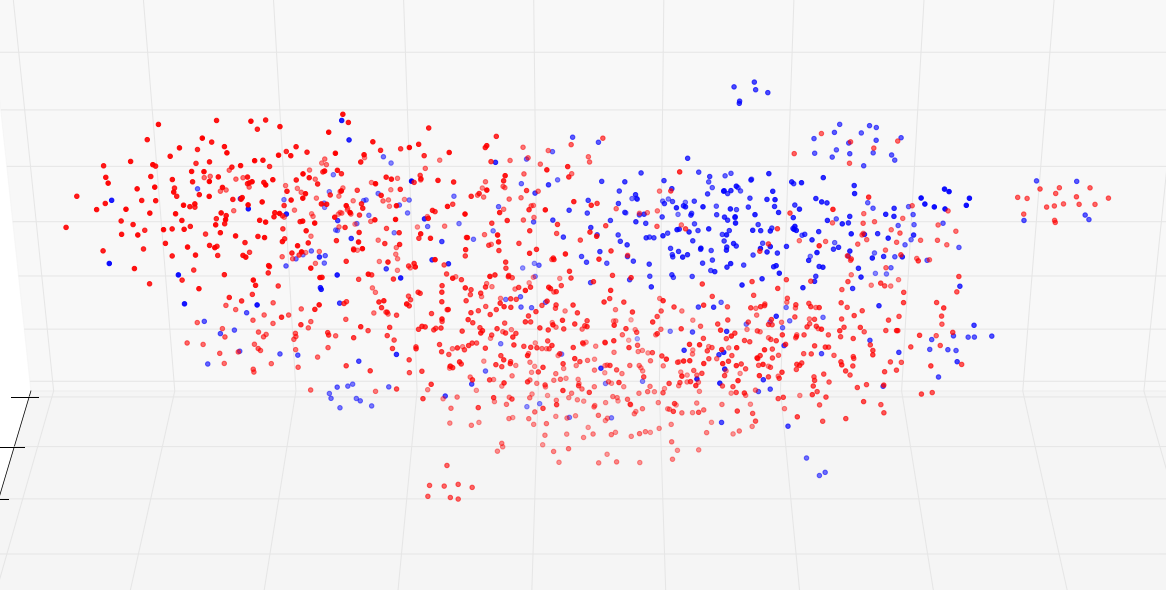

In [175]:
fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(elev=30, azim=180)              # elevation and angle
ax.dist=5                                  # distance
ax.scatter(vectors2d[:Nyn,0],vectors2d[:Nyn,1],vectors2d[:Nyn,2],color='r')
ax.scatter(vectors2d[Nyn:,0],vectors2d[Nyn:,1],vectors2d[Nyn:,2],color='b')

(array([   8.,    8.,    3.,    1.,    2.,    9.,    0.,    4.,    6.,
           1.,  678.,  515.,  399.,  225.,   47.,  137.,   30.,    9.,
         147.,  116.]),
 array([-1.97453332, -1.78090891, -1.58728451, -1.3936601 , -1.20003569,
        -1.00641128, -0.81278688, -0.61916247, -0.42553806, -0.23191366,
        -0.03828925,  0.15533516,  0.34895957,  0.54258397,  0.73620838,
         0.92983279,  1.12345719,  1.3170816 ,  1.51070601,  1.70433041,
         1.89795482]),
 <a list of 20 Patch objects>)

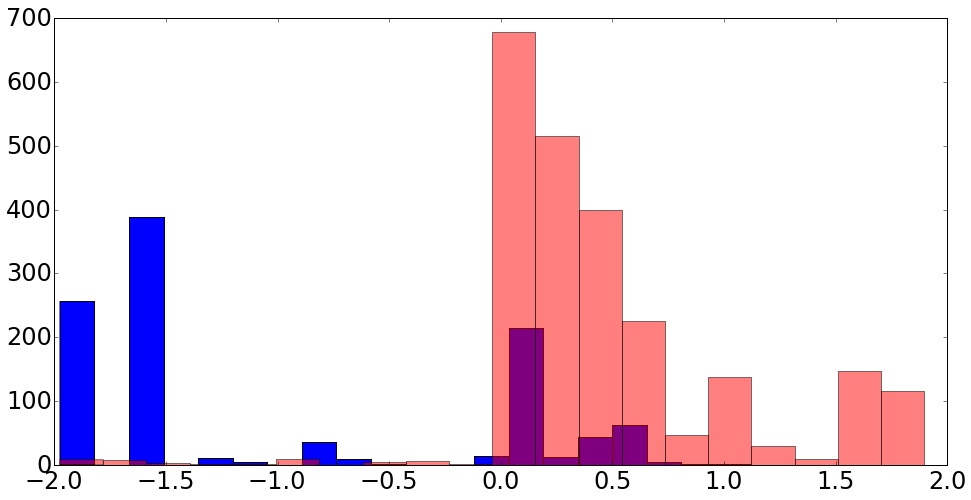

In [313]:
plt.hist(vectors2d[:Nyn],bins=20)
plt.hist(vectors2d[Nyn:],color='r',alpha=0.5,bins=20)

<h1> repeat on first 3 words </h1>

In [401]:
#extract first 3 words
words_yn=[word[:3] for word in qs_yn if len(word)>2]
words_oe=[word[:3] for word in qs_oe if len(word)>2]

<h3> vectorize and sum first 4 words </h3>

In [336]:
vectors_yn = []
words_yn_pass=[]
c1,c2,c3,c4,c5=1,1,0,0,0

for word in words_yn:
    try:
        vectors_yn.append(c1*QmodelB[word[0]]+c2*QmodelB[word[1]]+c3*QmodelB[word[2]]+c4*QmodelB[word[3]]+c5*QmodelB[word[4]])
        words_yn_pass.append(word)
    except (KeyError,IndexError):
        pass
vectors_oe = []
words_oe_pass=[]
for word in words_oe:
    try:
        vectors_oe.append(c1*QmodelB[word[0]]+c2*QmodelB[word[1]]+c3*QmodelB[word[2]]+c4*QmodelB[word[3]]+c5*QmodelB[word[4]])
        words_oe_pass.append(word)
    except (KeyError,IndexError):
        pass
vectors=vectors_yn+vectors_oe
words_pass=words_yn_pass+words_oe_pass

<h1> append vectors of first three words</h1>

In [402]:
vectors_yn = []
words_yn_pass=[]

for word in words_yn:
    #print(word)
    if (word[0] in QmodelB)&(word[1] in QmodelB)&(word[2] in QmodelB):
        vectors_yn.append(np.hstack((QmodelB[word[0]],QmodelB[word[1]],QmodelB[word[2]])))
        words_yn_pass.append(word)
    else:
        print('fail')
vectors_oe = []
words_oe_pass=[]
for word in words_oe:
    #print(word)
    if (word[0] in QmodelB)&(word[1] in QmodelB)&(word[2] in QmodelB):
        vectors_oe.append(np.hstack((QmodelB[word[0]],QmodelB[word[1]],QmodelB[word[2]])))
        words_oe_pass.append(word)
    else:
        print('fail')
vectors=vectors_yn+vectors_oe
words_pass=words_yn_pass+words_oe_pass

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


In [407]:
tsne = TSNE(n_components=2, random_state=0)
vectors2d = tsne.fit_transform(vectors)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


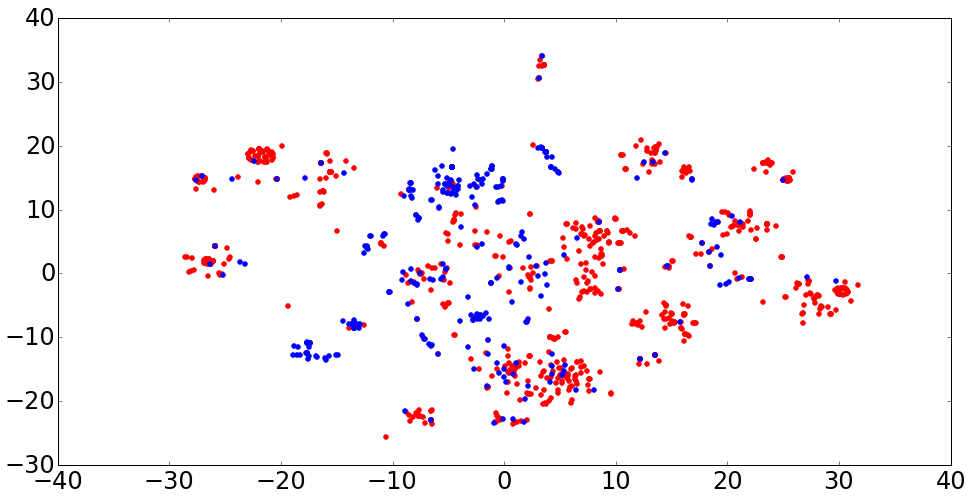

In [408]:
Nyn=len(vectors_yn)
plt.scatter(vectors2d[:Nyn,0],vectors2d[:Nyn,1],color='r')
plt.scatter(vectors2d[Nyn:,0],vectors2d[Nyn:,1],color='b')

#interesting_words=["i","does","how","is","could","should","anyone","will","where","can"]
#S=defaultdict(lambda:0)
#for ii,val in enumerate(vectors2d):
#    if ii%50==0:
        #print(' '.join(words_pass[ii]))
#        plt.text(val[0],val[1],' '.join(words_pass[ii][:2]),fontsize=12)
#xlim([-20,20])
#ylim([-20,30])

<h1> 3d plot </h1>

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


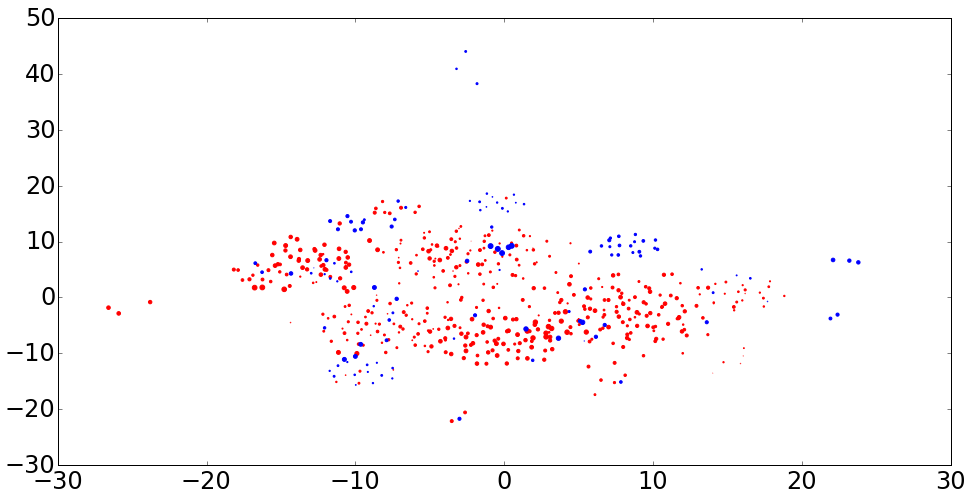

In [189]:
Nyn=len(vectors_yn)
plt.scatter(vectors2d[:Nyn,0],vectors2d[:Nyn,1],vectors2d[:Nyn,2],color='r')
plt.scatter(vectors2d[Nyn:,0],vectors2d[Nyn:,1],vectors2d[Nyn:,2],color='b')